# <center> End-to-end learning for music audio exploration <center/>
<center> <big> Semester Project - LTS2 Laboratory - EPFL <big/> <center/>
<center> <small> Justine Weber <small/> <center/>

### Configuration

In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Imports

Make the jupyter notebook use GPU ressources


In [2]:
from tensorflow.python.client import device_lib

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0","1","2" or "3"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Import useful libraries

In [3]:
import fnmatch
import re
import random
import time
import sys
import warnings
import librosa
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import itertools
from time import sleep

Import functions from external python files

In [4]:
sys.path.insert(0, "./python_files/")
from models import *
from tools import *
from loading import * 
from labels_analysis import *
from train import *
from ckpt_saving import *

## Constants

The following cells define all the needed data paths. <br>
You can either create a cell with your own paths, or modify one of the cells below with your custom paths.

### Local Machine

In [5]:
# Paths to folders containg data
MTT_DIR = "../MTT/"
MP3_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# Path to CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

# Path to folder where state of the network checkpoints are stored
LOGDIR = "checkpoints/"

LOCAL_DIRECTORIES = {'mp3_dir':MP3_DIRECTORY,
               'wav_dir':WAV_DIRECTORY,
               'logdir':LOGDIR,
               'labels_file':LABELS_FILE}

### LTS2 Server

This cell defines all the needed data paths, when running on LTS2 server.
Don't run this cell if you are not running the jupyter notebook on the LTS2 server ! (will overwrite the variables defined on the cell above).

You can either create a cell with your own paths, or modify the cell above with your custom paths.

In [6]:
# Paths to folders containg data
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

LOGDIR = MTT_DIR + "checkpoints/"

LTS2_DIRECTORIES = {'mp3_dir':DATA_DIRECTORY,
               'wav_dir':WAV_DIRECTORY,
               'logdir':LOGDIR,
               'labels_file':LABELS_FILE}

### Chosen one

Modify the following cell for selecting the right directories dictionary.

In [7]:
DIRECTORIES = LOCAL_DIRECTORIES

### Model Configuration

In [8]:
FILE_NB = 25880 
FILE_LENGTH = 465984
BASIC_CONFIG = {'numOutputNeurons':500,
               'nb_chunks':9,
               'chunk_size':51776,
               'tr_sample_size':3360,
               'tr_batch_size':20,
               'sample_rate':None,
               'train_dir':'0123456789abc',
               'test_dir':'def',
               'te_sample_size':60,
               'te_batch_size':20,
               'learning_rate':0.001,
               'epochs':50,
               'labels_name':['piano', 'rock'],
               'nb_labels':2,
               'file_type':'mp3',
               'max_checkpoints':5,
               'checkpoint_every':2}

assert (BASIC_CONFIG['chunk_size'] * BASIC_CONFIG['nb_chunks'] == FILE_LENGTH), \
"Given parameters for chunk size, number of chunks and length of audio files are not coherent. "+\
"Please check again"

assert (BASIC_CONFIG['tr_sample_size'] % BASIC_CONFIG['tr_batch_size'] ==0), \
"The parameter 'tr_sample_size' should be a multiple of 'tr_group_size'."

assert (BASIC_CONFIG['te_sample_size'] % BASIC_CONFIG['te_batch_size'] ==0), \
"The parameter 'te_sample_size' should be a multiple of 'te_group_size'."

assert (BASIC_CONFIG['nb_labels'] == len(BASIC_CONFIG['labels_name']) ), \
"The parameter 'nb_labels' should equal the length of parameter 'labels_name'."

assert (BASIC_CONFIG['file_type'] == 'wav' or BASIC_CONFIG['file_type'] == 'mp3'), \
"The parameter 'file_type' should be 'wav' or 'mp3'."

In [9]:
DEMO_CONFIG = {'numOutputNeurons':500,
               'nb_chunks':9,
               'chunk_size':51776,
               'tr_sample_size':60,
               'tr_batch_size':15,
               'sample_rate':None,
               'train_dir':'0123456789abc',
               'test_dir':'def',
               'te_sample_size':60,
               'te_batch_size':15,
               'learning_rate':0.001,
               'epochs':5,
               'labels_name':['piano', 'rock'],
               'nb_labels':2,
               'file_type':'mp3',
               'max_checkpoints':5,
               'checkpoint_every':2}


Modify the following cell for selecting the right configuration dictionary. (here is uses demo for illustration in the jupyter notebook but you should use BASIC_CONFIG for experiments)

In [10]:
CONFIG = DEMO_CONFIG

-------

## <center> Labels & Data Analysis <center/>

### Loading

In [11]:
labels, header = load_and_clean_labels(DIRECTORIES['labels_file'])
labels.head(6)

./python_files/loading.py:227: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels = pd.read_csv(labels_path, sep = '"\t"')


Loading csv file : 2.27


,clip_id,no_voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
5,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-30-59.mp3


### Analyse the dataset

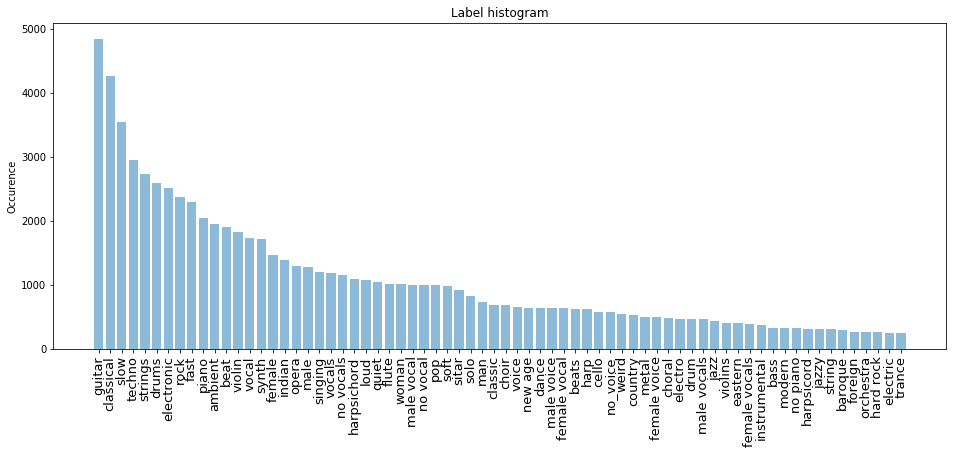

Number of songs :  25863
Number of labels :  188
Max number of songs tagged with the same label :  4852
Max number of labels for a single song :  27


In [12]:
nb_labels_per_song, nb_song_per_label, label_header_by_freq = label_stats(labels, header, plot=True)

In [13]:
best_10_labels = label_header_by_freq[:10]
best_30_labels = label_header_by_freq[:30]

### Co-occurence matrix


label_header_with_count: ['guitar (4852)', 'classical (4272)', 'slow (3547)', 'techno (2954)', 'strings (2729)', 'drums (2598)', 'electronic (2519)', 'rock (2371)', 'fast (2306)', 'piano (2056)']


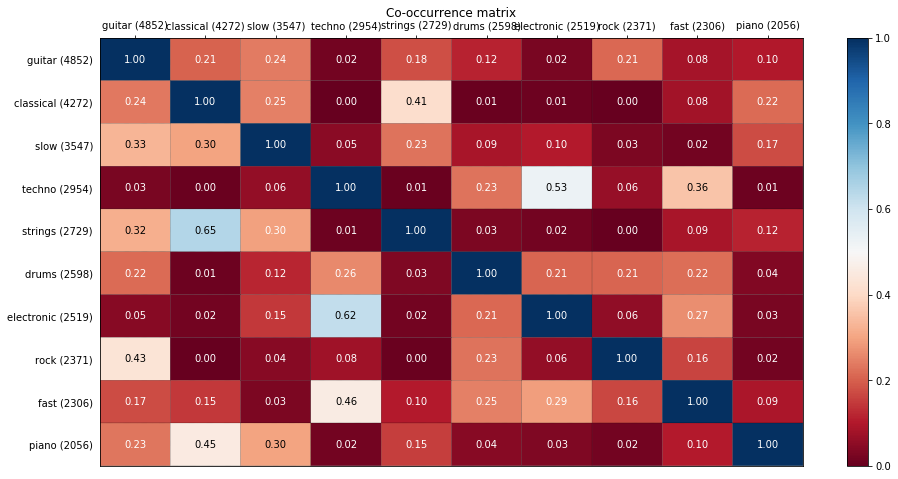

In [14]:
chosen_labels = best_10_labels
check_overlaps(chosen_labels, labels.loc[:,chosen_labels].values.astype(int))

------

## <center> Neural network <center/>

### Training Functions

These function are intended to prepare trainings with particular setting we wish to test. You are encouraged to enrich this section with other function.

In [15]:
def train_basic() :
    train_loss_results, train_auc_results, ckpt = train_and_load_restore(CONFIG, DIRECTORIES, labels)
    
    return train_loss_results, train_auc_results, ckpt

In [16]:
def train_custom_batch(batch_size, sample_size) :
    
    assert(sample_size % batch_size ==0), "Sample size should be a multiple of batch size."
    
    my_config = CONFIG.copy()
    my_config['tr_batch_size'] = batch_size
    my_config['tr_sample_size'] = sample_size
    
    train_loss_results, train_auc_results = train_and_load_restore(my_config, DIRECTORIES, labels)
    
    return train_loss_results, train_auc_results

In [17]:
def train_custom_labels(labels_name, nb_labels, sample_size=None) :
    
    my_config = CONFIG.copy()
    
    if sample_size is None:
        warnings.warn("When modifying the labels, you should also consider modifying the \
        sample size, make sure you thought about this.", FutureWarning, stacklevel=2)
        
    else :
        assert(sample_size % config['batch_size'] ==0), "Sample size should be a multiple of batch size."
        my_config['tr_sample_size'] = sample_size
    
    assert(len(labels_name) == nb_labels), \
    "Length of list of labels (labels_name) should equal parameter nb_labels."
    
    my_config['labels_name'] = labels_name
    my_config['nb_labels'] = nb_labels
    
    train_loss_results, train_auc_results = train_and_load_restore(my_config, DIRECTORIES, labels)
    
    return train_loss_results, train_auc_results

### Experiment(s)

In [18]:
train_loss_results, train_auc_results, ckpt = train_basic()

Using default logdir: checkpoints/train/2019-06-07T20-37-55
All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Start training...


>> Total loading time : 0.70 sec
Group 0 done. 3 left.
Epoch:   0, Time (in sec): 61.54, Loss: 0.6216, AUC : 0.4861

Storing checkpoint to checkpoints/train/2019-06-07T20-37-55 ... Done.
>> Total loading time : 0.65 sec
Group 0 done. 3 left.
Epoch:   1, Time (in sec): 56.18, Loss: 0.5591, AUC : 0.8942

>> Total loading time : 0.61 sec
Group 0 done. 3 left.
Epoch:   2, Time (in sec): 58.77, Loss: 0.5252, AUC : 0.9281

Storing checkpoint to checkpoints/train/2019-06-07T20-37-55 ... Done.
>> Total loading time : 0.63 sec
Group 0 done. 3 left.
Epoch:   3, Time (in sec): 52.80, Loss: 0.5246, AUC : 0.9486

>> Total loading time : 0.63 sec
Group 0 done. 3 left.
Epoch:   4, Time (in sec): 57.83, Loss: 0.5154, AUC : 0.9583

Storing checkpoint to checkpoints/train/2019-06-07T20-37-55 ... Done.

Total time: 4.82 minutes.


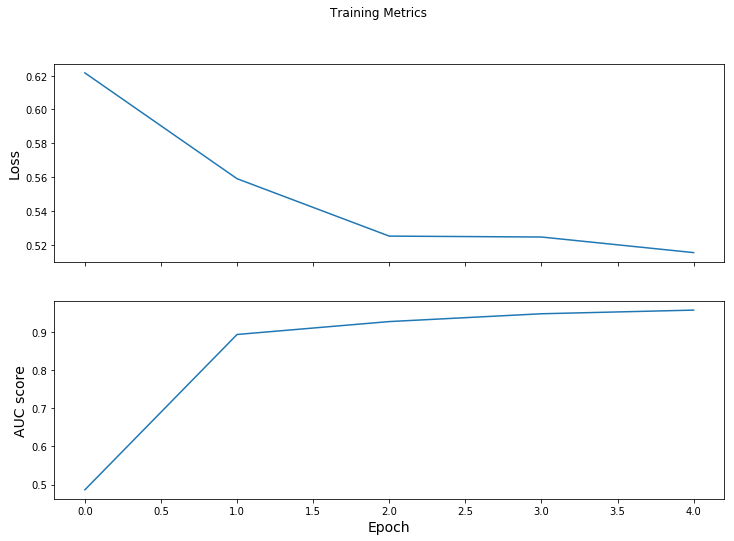

In [19]:
#flat = flatten_loss_auc_results(train_loss_results, train_auc_results)
avg = average_loss_auc_results(train_loss_results, train_auc_results)

#plot_auc_loss(flat[0], flat[1])
plot_auc_loss(avg[0], avg[1])

## Testing

This part gives a basis for getting scores on the validation set and test set. 

In [20]:
ckpt_name = ckpt[len('checkpoints/'):]+"/model.ckpt-"+str(CONFIG['epochs']-1)

In [21]:
def validing(model_ckpt):
    testing_validing(CONFIG, DIRECTORIES, labels, model_ckpt, validation=True)

In [22]:
def testing(model_ckpt):
    testing_validing(CONFIG, DIRECTORIES, labels, model_ckpt, validation=False)

In [23]:
validing(ckpt_name)

All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Restoring model from train/2019-06-07T20-37-55/model.ckpt-4
INFO:tensorflow:Restoring parameters from checkpoints/train/2019-06-07T20-37-55/model.ckpt-4
Model restored.
>> Total loading time : 0.63 sec
Group 0 done. 3 left.
Time (in sec): 9.56, Loss: 0.7026, AUC : 0.0000

>> Total loading time : 0.61 sec
Group 1 done. 2 left.
Time (in sec): 18.74, Loss: 0.7185, AUC : 0.7681

>> Total loading time : 0.63 sec
Group 2 done. 1 left.
Time (in sec): 27.58, Loss: 0.7232, AUC : 0.6469

>> Total loading time : 0.61 sec
Group 3 done. 0 left.
Time (in sec): 36.54, Loss: 0.6931, AUC : 0.6178

Total time: 0.61 minutes.


In [24]:
testing(ckpt_name)

All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Restoring model from train/2019-06-07T20-37-55/model.ckpt-4
INFO:tensorflow:Restoring parameters from checkpoints/train/2019-06-07T20-37-55/model.ckpt-4
Model restored.
>> Total loading time : 0.63 sec
Group 0 done. 3 left.
Time (in sec): 9.75, Loss: 0.7043, AUC : 0.0000

>> Total loading time : 0.63 sec
Group 1 done. 2 left.
Time (in sec): 18.79, Loss: 0.7249, AUC : 0.5407

>> Total loading time : 0.66 sec
Group 2 done. 1 left.
Time (in sec): 28.20, Loss: 0.6919, AUC : 0.4951

>> Total loading time : 0.64 sec
Group 3 done. 0 left.
Time (in sec): 37.17, Loss: 0.6901, AUC : 0.4846

Total time: 0.62 minutes.
